# Deep Walk 图嵌入：维基百科词条

## 1. 环境参考

### 参考资料
https://github.com/prateekjoshi565/DeepWalk


### 安装工具包

In [1]:
!pip install networkx gensim pandas numpy tqdm scikit-learn matplotlib

Looking in indexes: https://mirrors.tuna.tsinghua.edu.cn/pypi/web/simple


### 导入工具包

In [2]:
# 图数据挖掘
import networkx as nx

# 数据分析
import pandas as pd
import numpy as np

# 随机数与进度条
import random
from tqdm import tqdm

# 数据可视化
import matplotlib.pyplot as plt
%matplotlib inline


## 2. 数据

### 获取数据

爬虫网站：https://densitydesign.github.io/strumentalia-seealsology/

1. 设置 distance

2. 输入链接：

https://en.wikipedia.org/wiki/Computer_vision

https://en.wikipedia.org/wiki/Deep_learning

https://en.wikipedia.org/wiki/Convoutional_neural_network

https://en.wikipedia.org/wiki/Decision_tree

https://en.wikipedia.org/wiki/Support_vector_machine


3. 点击 `START CRAWLING`, 爬取完成点击 `STOP`

4. Download 下载为 TSV 文件（以`\t`分割的 CSV 文件）。

In [3]:
df = pd.read_csv("seealsology-data.tsv", sep='\t')

In [4]:
df.head()

,source,target,depth
0,support vector machine,in situ adaptive tabulation,1
1,support vector machine,kernel machines,1
2,support vector machine,fisher kernel,1
3,support vector machine,platt scaling,1
4,support vector machine,polynomial kernel,1


In [5]:
df.shape

(4232, 3)

### 构建无向图

In [6]:
G = nx.from_pandas_edgelist(df, 'source', 'target', edge_attr=True, create_using=nx.Graph())

In [7]:
# 节点个数
len(G)

3059

### 可视化

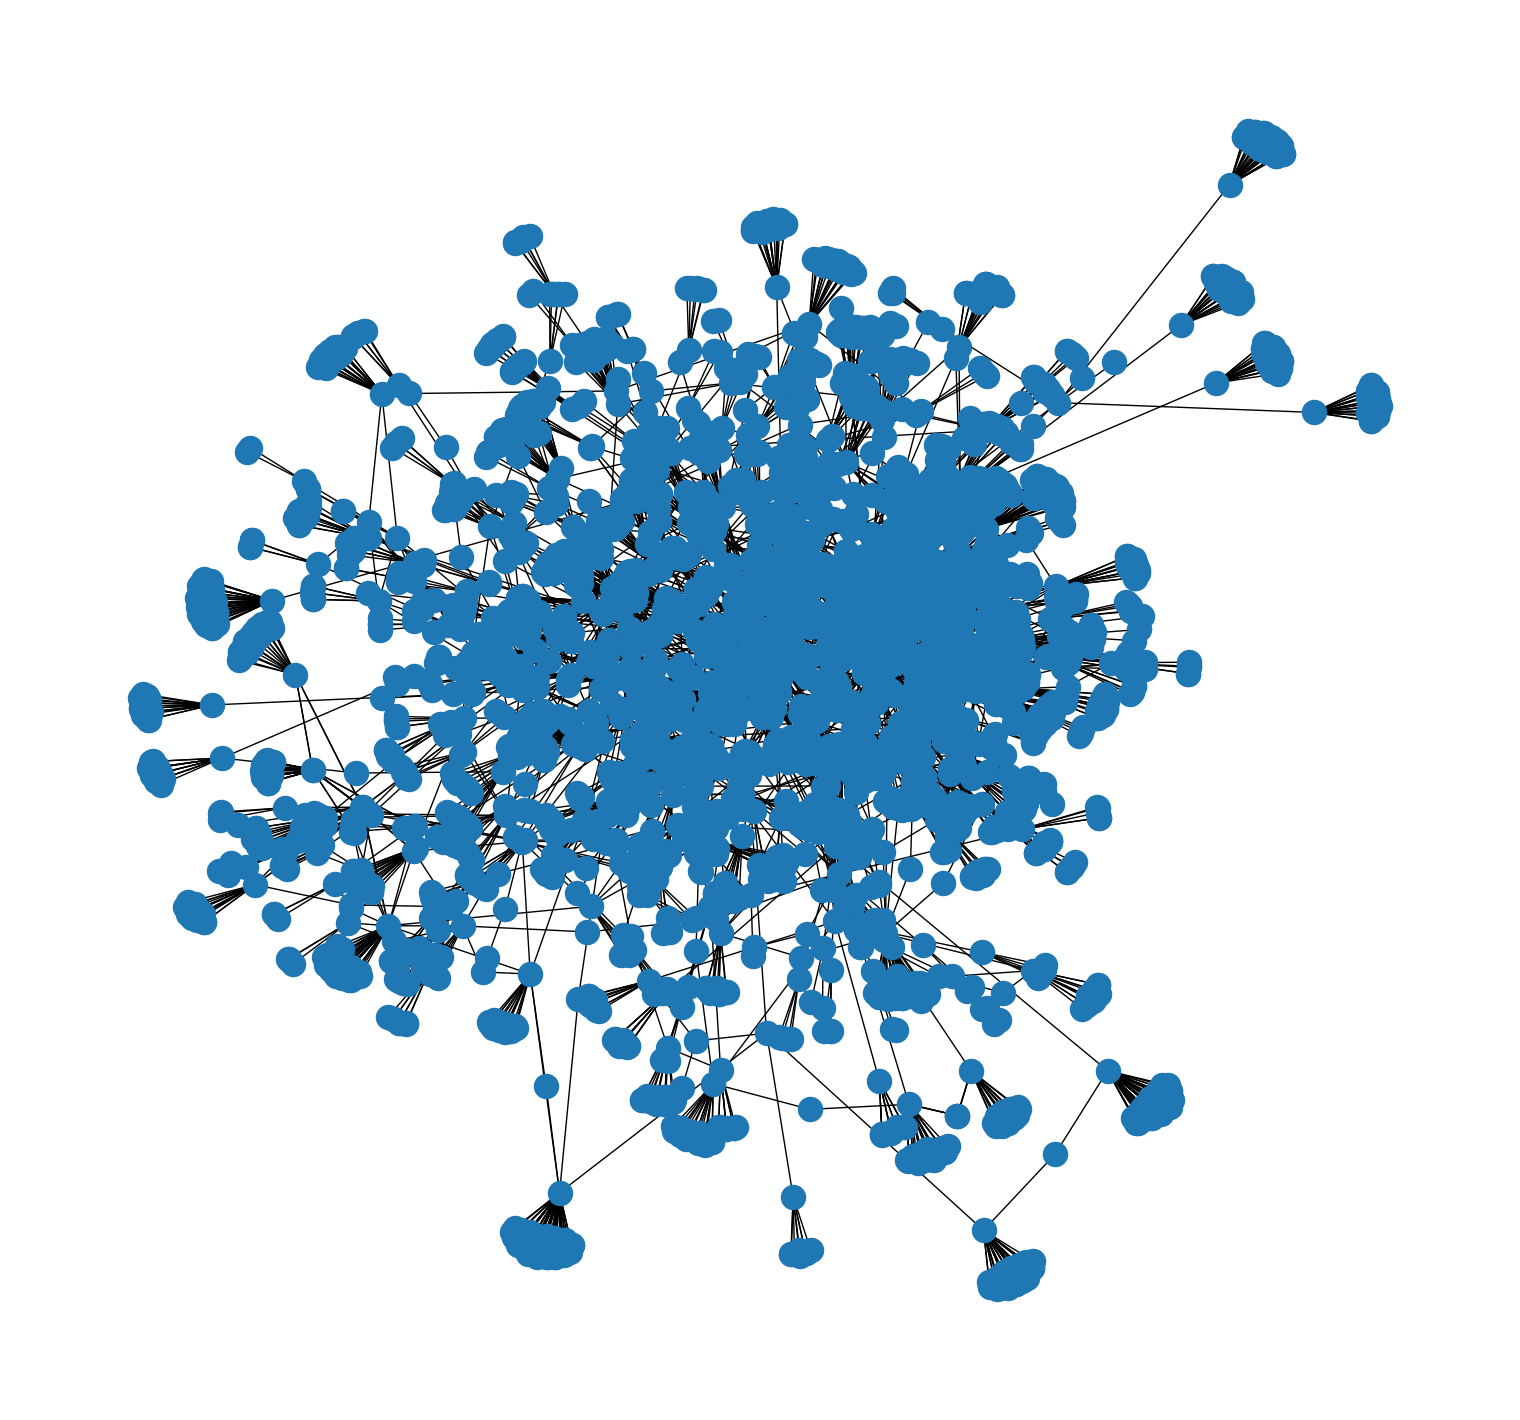

In [8]:
plt.figure(figsize=(15, 14))
nx.draw(G)
plt.show()

## 3. 随机游走

### randomwalk 函数

In [9]:
def get_randomwalk(node, path_length):
    '''
    输入起始节点和路径长度，生成随机游走节点序列
    '''
    random_walk = [node]
    for i in range(path_length-1):
        # 汇总邻接节点
        temp = list(G.neighbors(node))
        temp = list(set(temp) - set(random_walk))
        if len(temp) == 0:
            break
        # 从邻接节点中随机选择下一个节点
        random_node = random.choice(temp)
        random_walk.append(random_node)
        node = random_node
        
    return random_walk


In [10]:
all_nodes = list(G.nodes())

In [12]:
get_randomwalk('computer vision', 5)

['computer vision',
 'machine vision glossary',
 'glossary of artificial intelligence',
 'artificial intelligence',
 'organoid intelligence']

### 生成随机游走序列

In [13]:
gamma = 10   # 每个节点作为起始节点生成随机游走序列个数
walk_length = 5   # 随机游走序列最大长度

In [14]:
random_walks = []

for nd in tqdm(all_nodes):   # 遍历每个节点
    for i in range(gamma):   # 每个节点作为起始点生成 gamma 个随机游走序列
        rdwk = get_randomwalk(nd, walk_length)
        random_walks.append(rdwk)


100%|████████████████████████████████████████████████████████████████████████████| 3059/3059 [00:00<00:00, 30093.95it/s]


In [15]:
# 生成随机游走序列的个数
len(random_walks)

30590

In [17]:
random_walks[0]

['support vector machine', 'relevance vector machine', 'kernel trick']

## 4. 模型

### 训练 Word2Vec 模型

In [18]:
# 自然语言处理
from gensim.models import Word2Vec

In [19]:
model = Word2Vec(vector_size=256, # Embedding 维数
                 window=4,        # 窗口宽度
                 sg=1,            # Skip-Gram
                 negative=10,     # 负采样
                 alpha=0.03,      # 初始学习率
                 min_alpha=0.0007,# 最小学习率
                 seed=14          # 随机数种子
                )

In [20]:
# 用随机游走序列构建词汇表
model.build_vocab(random_walks, progress_per=2)

In [21]:
# 训练（耗时 1 分钟）
model.train(random_walks, total_examples=model.corpus_count, epochs=50, report_delay=1)

(5623725, 5679950)

### 分析 Word2Vec 结果

In [22]:
# 查看某个节点的 Embedding
model.wv.get_vector('computer vision').shape

(256,)

In [23]:
model.wv.get_vector('computer vision')

array([-0.95459837,  0.10292508, -0.28316122,  0.34142157, -0.00524048,
        0.09371996, -0.1954719 , -0.25347382,  0.51394266,  0.36131492,
        0.49506772,  0.1907984 , -0.6219965 , -0.5140934 , -0.01667919,
       -0.62039286, -0.05152594,  0.11786714,  0.18947525,  0.19846195,
       -0.11716247,  0.4700267 ,  0.07052463, -0.17666382,  0.1671837 ,
        0.24031273, -0.18862735, -0.15001939, -0.15928511, -0.13938765,
       -0.05735731, -0.17796549, -0.20125604, -0.13714062,  0.02854507,
       -0.3297002 ,  0.21914023, -0.03728085, -0.42431426,  0.28924662,
       -0.07030115,  0.153452  ,  0.02109604, -0.5424473 , -0.5128256 ,
        0.09319318, -0.18759303, -0.20778346,  0.01962802,  0.2059087 ,
        0.49449265, -0.43316683,  0.47074154,  0.32398415,  0.18804422,
        0.30941215, -0.16319014,  0.5086255 , -0.4054713 ,  0.18189834,
       -0.0757796 ,  0.01394054,  0.29209548, -0.20624508,  0.04370715,
       -0.22285934, -0.1998267 , -0.07965406, -0.56047654,  0.39

In [24]:
# 找相似词语
model.wv.similar_by_word('computer vision')

[('computational imaging', 0.7198930978775024),
 ('teknomo–fernandez algorithm', 0.6524918079376221),
 ('vectorization (image tracing)', 0.6257413625717163),
 ('h-maxima transform', 0.6218506097793579),
 ('egocentric vision', 0.6183371543884277),
 ('multispectral imaging', 0.6168951988220215),
 ('sound recognition', 0.6164405345916748),
 ('ridge detection', 0.6114603281021118),
 ('google goggles', 0.6109517216682434),
 ('medical intelligence and language engineering lab', 0.6081306338310242)]

## 5. PCA 降维可视化

### 全部词条

In [25]:
# 可视化全部词条的二维 Embedding
X = model.wv.vectors

In [26]:
from sklearn.decomposition import PCA

# 将 Embedding 用 PCA 降维到 2 维
pca = PCA(n_components=2)
embed_2d = pca.fit_transform(X)

In [27]:
embed_2d.shape

(3059, 2)

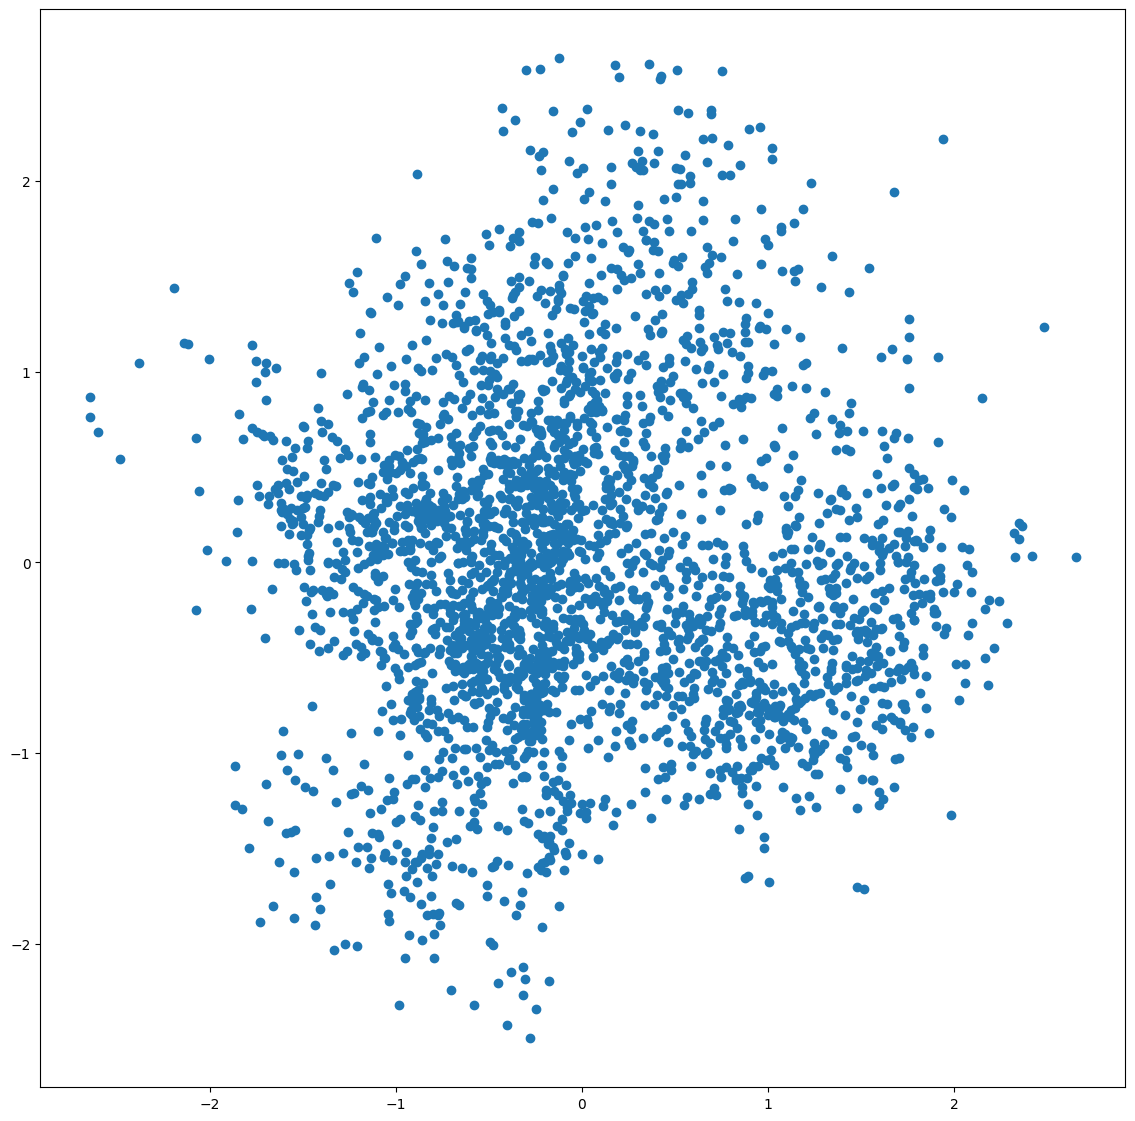

In [28]:
plt.figure(figsize=(14,14))
plt.scatter(embed_2d[:, 0], embed_2d[:, 1])
plt.show()

### 某个词条

In [29]:
# 可视化某个词条的二维 Embedding
term = 'computer vision'
term_256d = model.wv[term].reshape(1, -1)
term_256d.shape

(1, 256)

In [30]:
term_2d = pca.transform(term_256d)

In [31]:
term_2d

array([[-0.6757479,  0.6024744]], dtype=float32)

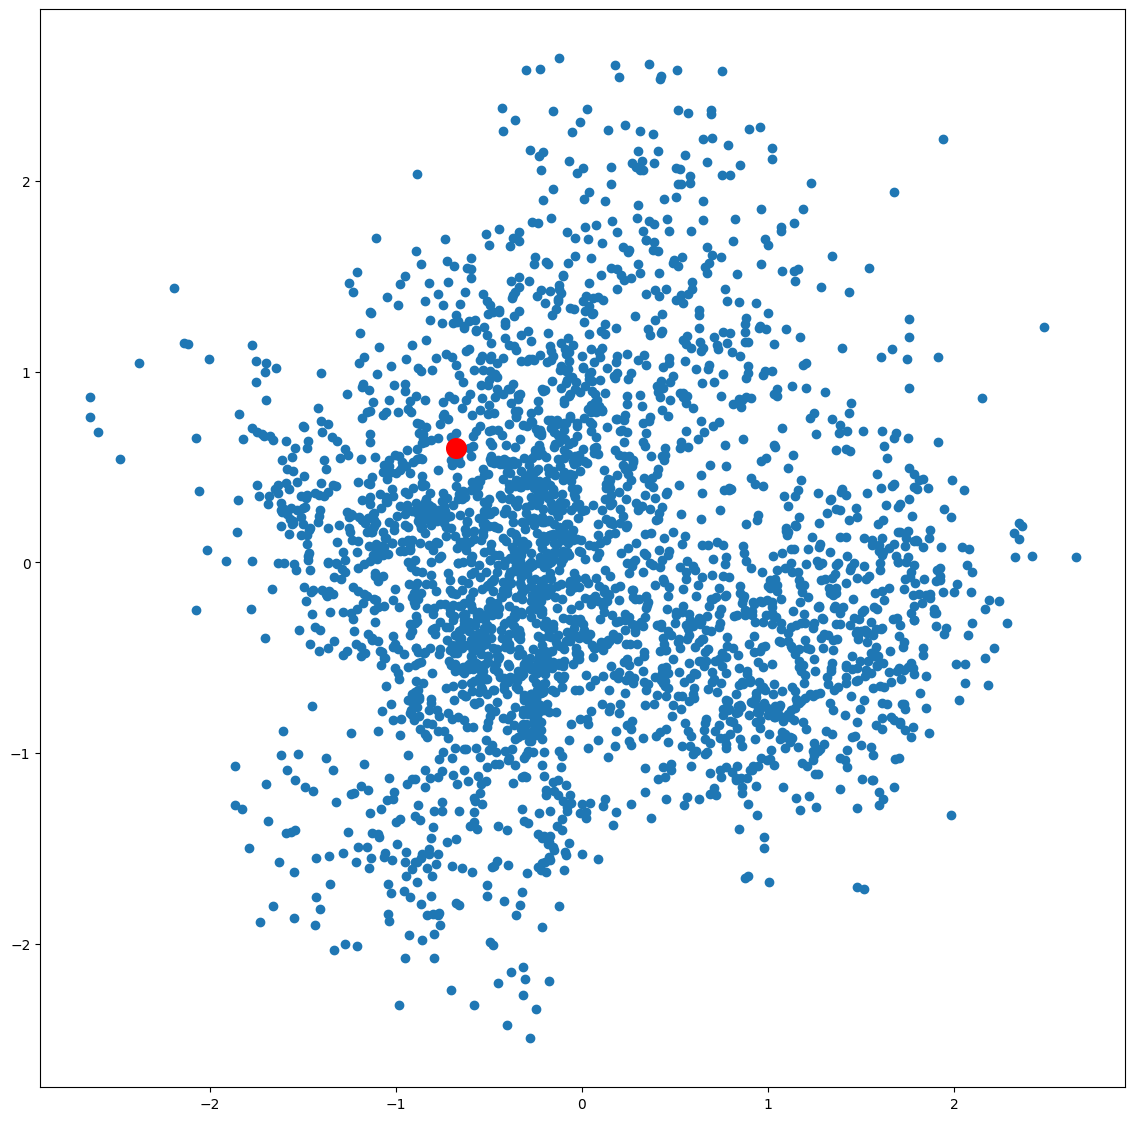

In [32]:
plt.figure(figsize=(14,14))
plt.scatter(embed_2d[:, 0], embed_2d[:, 1])
plt.scatter(term_2d[:, 0], term_2d[:, 1], c='r', s=200)
plt.show()

### 某些词条

In [33]:
# 可视化某些词条的二维 Embedding
# 计算 PageRank 重要度
pagerank = nx.pagerank(G)
# 从高到低排序
node_importance = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)

In [47]:
# 取最高的 n 个节点
n = 30
terms_chosen = []
for nd in node_importance[:n]:
    terms_chosen.append(nd[0])


In [48]:
# 手动补充新节点
terms_chosen.extend(['computer vision', 'deep learning'])

In [49]:
terms_chosen

['cloud computing',
 'electromagnetic wave equation',
 'spatial dependence',
 '3d modeling',
 'empathy',
 'psychoacoustics',
 'evolutionary psychology',
 'superlens',
 'wearable computer',
 'cognitive science',
 'decision theory',
 'system dynamics',
 'accessibility',
 'brain–computer interface',
 'simulated consciousness',
 'visual perception',
 'artificial neural network',
 'turing test',
 'cognitive psychology',
 'recognition of human individuals',
 'transhumanism',
 'speech repetition',
 'embodied cognition',
 'finite element method',
 'computational neuroscience',
 'fourier analysis',
 'interval finite element',
 'n170',
 'graphical user interface',
 'tensor',
 'computer vision',
 'deep learning']

In [50]:
# 输入词条，输出词典中的索引号
term2index = model.wv.key_to_index
# 反之
index2term = model.wv.index_to_key

In [51]:
term_index = np.array(term2index.values())

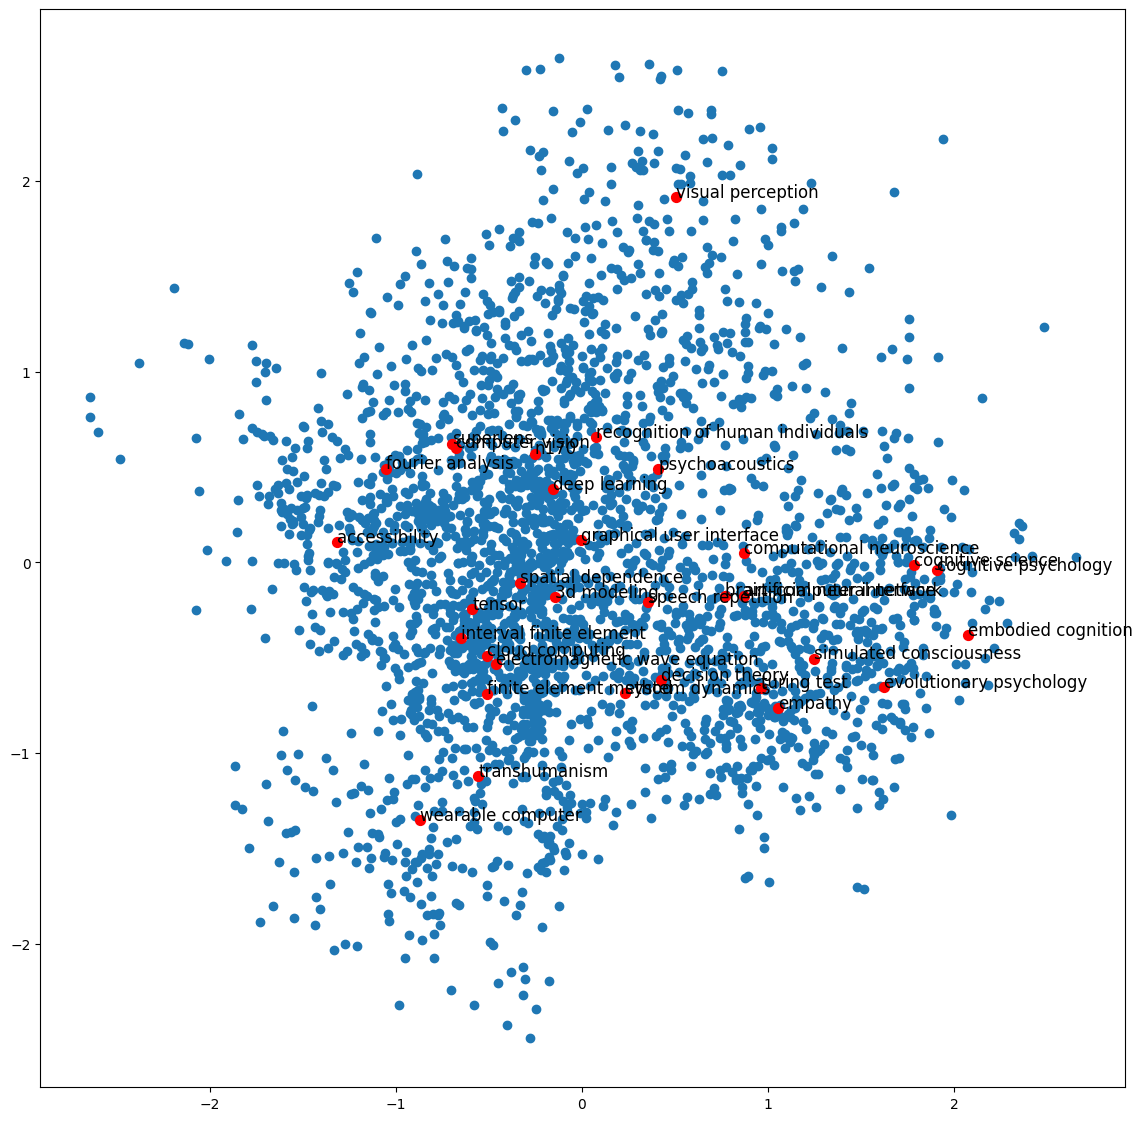

In [53]:
# 可视化全部词条和关键词的二维 Embedding
plt.figure(figsize=(14,14))
plt.scatter(embed_2d[:, 0], embed_2d[:, 1])

for item in terms_chosen:
    idx = term2index[item]
    plt.scatter(embed_2d[idx, 0], embed_2d[idx, 1], c='r', s=50)
    plt.annotate(item, xy=(embed_2d[idx, 0], embed_2d[idx, 1]), c='k', fontsize=12)

plt.show()

## 6. TSNE 降维可视化

### 全部词条

In [54]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, n_iter=1000)
embed_2d = tsne.fit_transform(X)

/opt/anaconda3/envs/graph/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


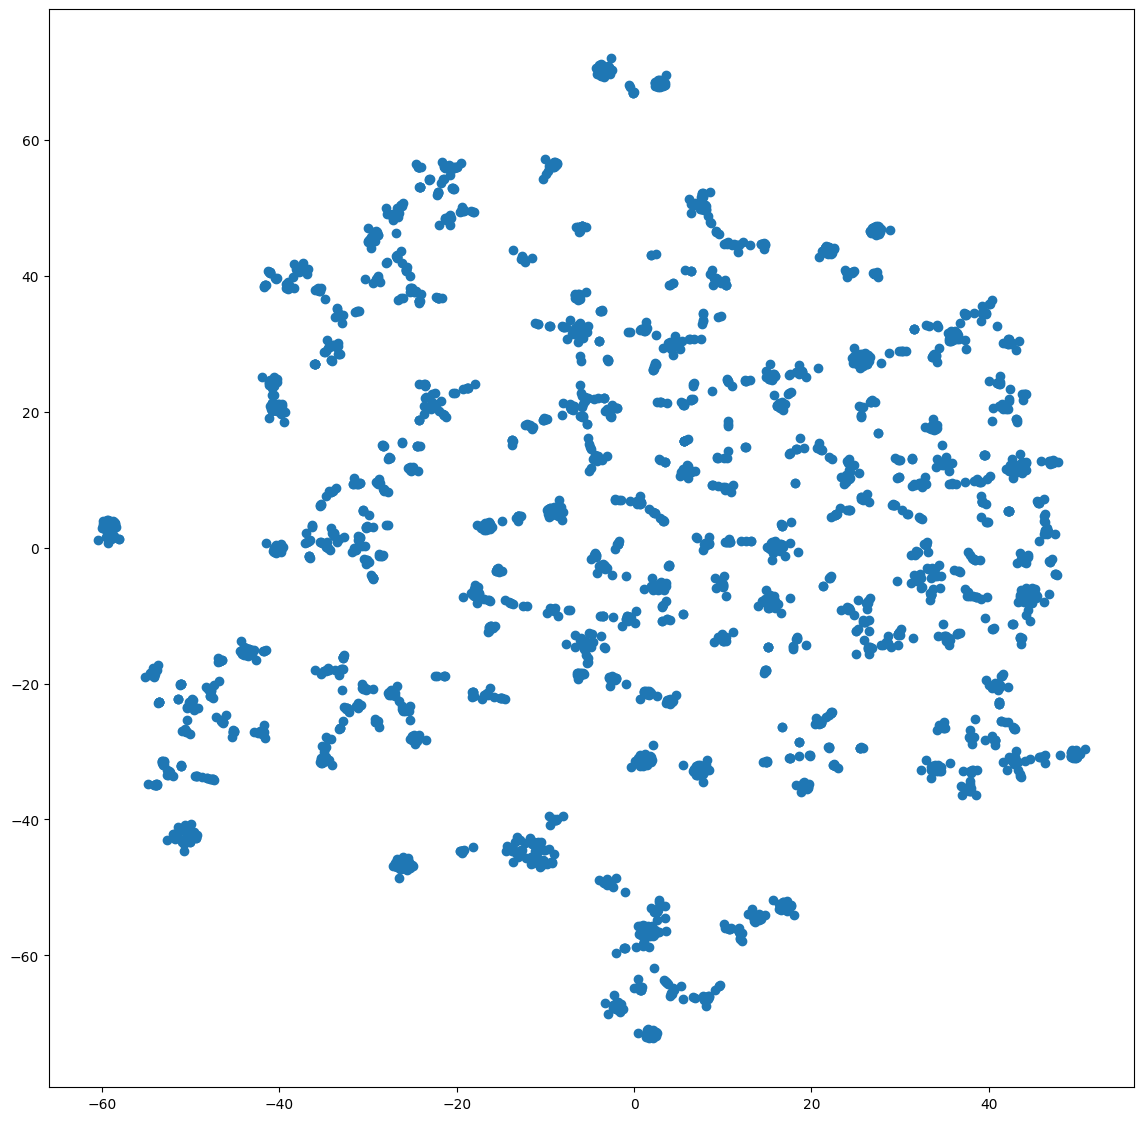

In [55]:
plt.figure(figsize=(14,14))
plt.scatter(embed_2d[:,0], embed_2d[:,1])
plt.show()

### 某些词条

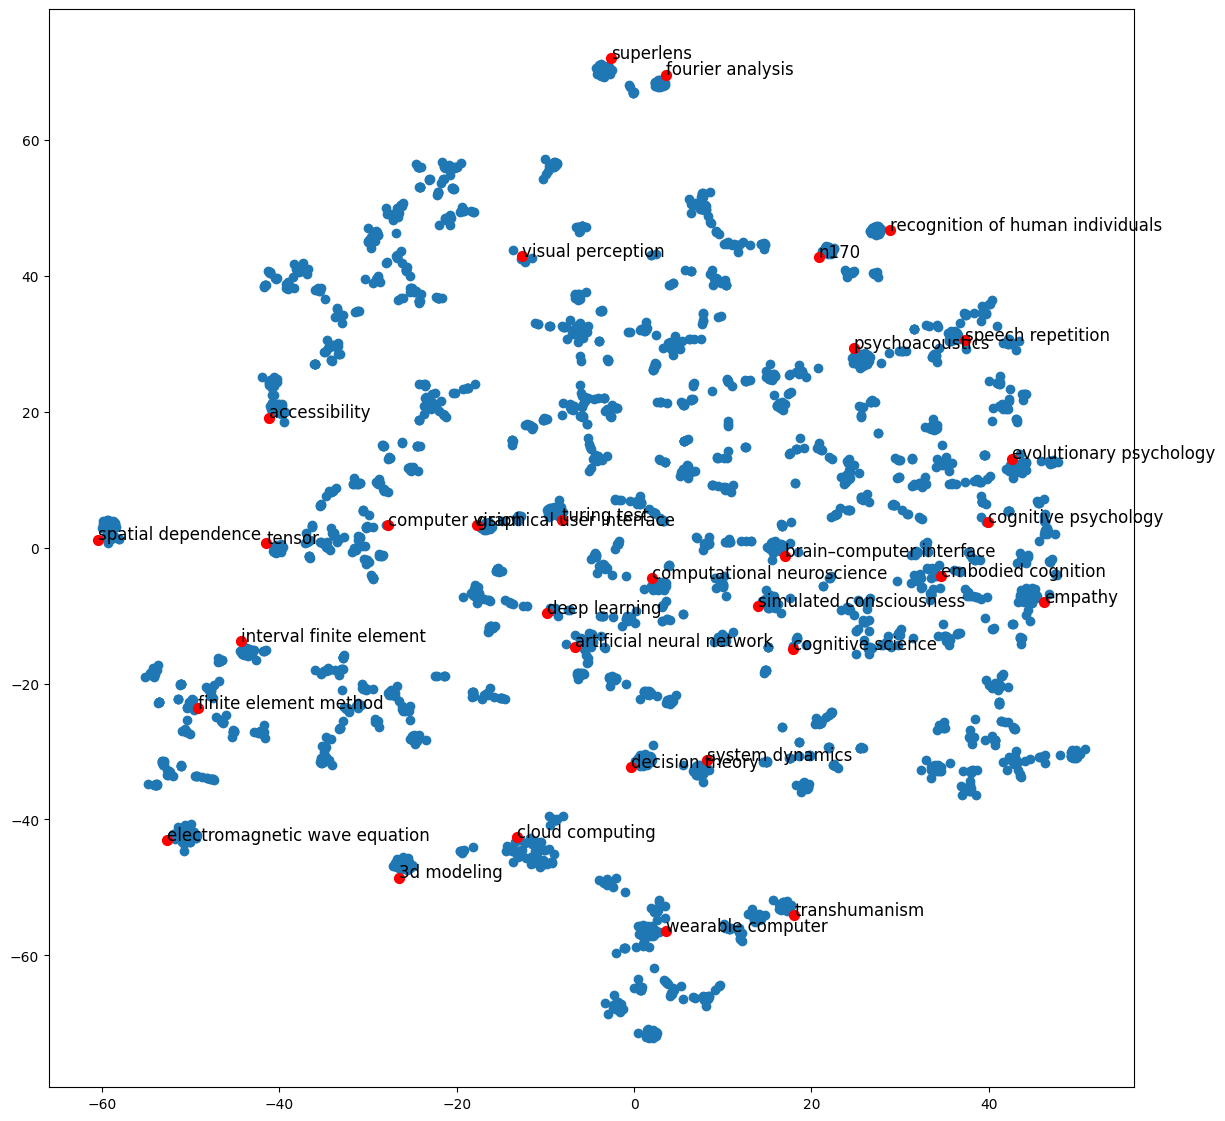

In [56]:
# 可视化全部词条和关键词的二维 Embedding
plt.figure(figsize=(14,14))
plt.scatter(embed_2d[:, 0], embed_2d[:, 1])

for item in terms_chosen:
    idx = term2index[item]
    plt.scatter(embed_2d[idx, 0], embed_2d[idx, 1], c='r', s=50)
    plt.annotate(item, xy=(embed_2d[idx, 0], embed_2d[idx, 1]), c='k', fontsize=12)

plt.show()

In [57]:
embed_2d.shape

(3059, 2)

### 导出

In [58]:
terms_chosen_mask = np.zeros(X.shape[0])
for item in terms_chosen:
    idx = term2index[item]
    terms_chosen_mask[idx] = 1


In [59]:
df = pd.DataFrame()
df['X'] = embed_2d[:, 0]
df['Y'] = embed_2d[:, 1]
df['item'] = model.wv.index_to_key
df['pagerank'] = pagerank.values()
df['chosen'] = terms_chosen_mask

In [60]:
df

,X,Y,item,pagerank,chosen
0,-13.242397,-42.560059,cloud computing,0.001352,1.0
1,42.664997,13.116780,evolutionary psychology,0.000699,1.0
2,-12.628043,42.939220,visual perception,0.000623,1.0
3,17.878042,-14.927996,cognitive science,0.000292,1.0
4,39.976368,3.763149,cognitive psychology,0.000255,1.0
...,...,...,...,...,...
3054,2.317700,-71.532204,browser isolation,0.000150,0.0
3055,15.404965,0.663236,neural engineering,0.000150,0.0
3056,40.051682,-20.218977,level of analysis,0.000150,0.0
3057,38.300884,9.790667,social cognitive and affective neuroscience,0.000150,0.0


In [61]:
df.to_csv('tsne_vis_2d.csv', index=False)

### 三维 TSNE

In [62]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, n_iter=1000)
embed_3d = tsne.fit_transform(X)

/opt/anaconda3/envs/graph/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [63]:
df = pd.DataFrame()
df['X'] = embed_3d[:, 0]
df['Y'] = embed_3d[:, 1]
df['Z'] = embed_3d[:, 1]
df['item'] = model.wv.index_to_key
df['pagerank'] = pagerank.values()
df['chosen'] = terms_chosen_mask

In [64]:
df

,X,Y,Z,item,pagerank,chosen
0,-5.344084,-13.896581,-13.896581,cloud computing,0.001352,1.0
1,12.959835,1.637353,1.637353,evolutionary psychology,0.000699,1.0
2,-9.399863,5.780833,5.780833,visual perception,0.000623,1.0
3,2.417569,-12.603775,-12.603775,cognitive science,0.000292,1.0
4,5.512045,1.471242,1.471242,cognitive psychology,0.000255,1.0
...,...,...,...,...,...,...
3054,-7.936583,-12.397557,-12.397557,browser isolation,0.000150,0.0
3055,9.576207,-11.376499,-11.376499,neural engineering,0.000150,0.0
3056,18.333593,-2.940028,-2.940028,level of analysis,0.000150,0.0
3057,7.171093,3.361520,3.361520,social cognitive and affective neuroscience,0.000150,0.0


In [65]:
df.to_csv('tsne_vis_3d.csv', index=False)

## 7. 课后作业*

> 用 `tsne_vis_2d.csv` 和 `tsne_vis_3d.csv` 做可视化
> 
> 参考代码：https://echarts.apache.org/examples/zh/editor.html?c=scatter3d&gl=1&theme=dark